In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# GPU use garnalaai
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


### 1. Data preparation

The images included in the data/cats-and-dogs directory are a random subset of the full cat and dog dataset from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
# Organize the data into train, valid, test dirs

os.chdir('data/cat-vs-dog')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    

    for c in random.sample(glob.glob("cat*"), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob("dog*"), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob("cat*"), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob("dog*"), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob("cat*"), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob("dog*"), 50):
        shutil.move(c, 'test/dog')

os.chdir('../../')

In [4]:
train_path  = 'data/cat-vs-dog/train'
valid_path = 'data/cat-vs-dog/valid'
test_path = 'data/cat-vs-dog/test'

* "ImageDataGenerator" generates batches of image data with real-time data augmentation
    *  It helps efficiently load and preprocess images in batches to be used in training or evaluation
    
* "preprocessing_function" parameter is used to apply a specific preprocessing function to each image in the batch

* ".flow_from_directory(...)" generates batches of images from a directory 
    * It loads images from the specified train_path directory, applies the preprocessing function to each image, and returns batches of images with their corresponding labels.


In [5]:
# setting up a data generator to load and preprocess images from the 'cat' and 'dog' subdirectories in the train_path directory.

# Create the ImageDataGenerator objects with VGG16 preprocessing.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(244, 244), classes=['cat', 'dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(244, 244), classes=['cat', 'dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(244, 244), classes=['cat', 'dog'], batch_size=10)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
# verify 

assert train_batches.n == 1000   # "Train batches should have 1000 batches."
assert valid_batches.n == 200   # "Valid batches should have 200 batches."
assert test_batches.n == 100   # "Test batches should have 100 batches."

# Verify the number of classes in all datasets.
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2 # "All datasets should have 2 classes (cat and dog)."


In [7]:
# grab a single batch of images and crossponding labels
imgs, labels = next(train_batches)  # batch_size is 10. So this should be 10 image along with the 10 corresponding labels

In [8]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

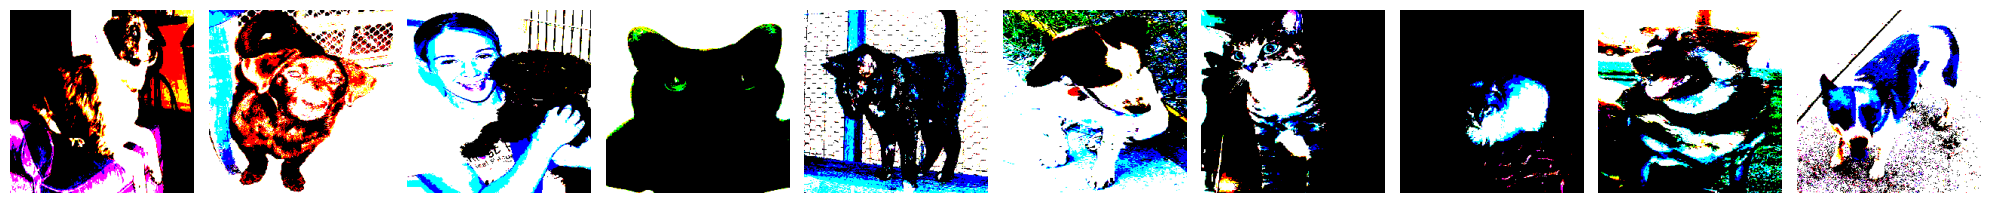

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

### 2. Build a CNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(244, 244, 3)), 
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=2, activation='softmax'),  # Two units for 'cat' and 'dog' classes.
])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [12]:
# prepare model for compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train the model
# model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10
100/100 - 98s - loss: 37.3335 - accuracy: 0.5770 - val_loss: 7.8239 - val_accuracy: 0.6050 - 98s/epoch - 981ms/step
Epoch 2/10
100/100 - 106s - loss: 4.5253 - accuracy: 0.7750 - val_loss: 4.9239 - val_accuracy: 0.6650 - 106s/epoch - 1s/step
Epoch 3/10
100/100 - 100s - loss: 0.6699 - accuracy: 0.9040 - val_loss: 6.2002 - val_accuracy: 0.6200 - 100s/epoch - 998ms/step
Epoch 4/10
100/100 - 103s - loss: 0.4861 - accuracy: 0.9350 - val_loss: 5.8878 - val_accuracy: 0.6050 - 103s/epoch - 1s/step
Epoch 5/10
100/100 - 98s - loss: 0.1903 - accuracy: 0.9690 - val_loss: 6.2859 - val_accuracy: 0.6350 - 98s/epoch - 981ms/step
Epoch 6/10
100/100 - 92s - loss: 0.2093 - accuracy: 0.9680 - val_loss: 5.2951 - val_accuracy: 0.6200 - 92s/epoch - 917ms/step
Epoch 7/10
100/100 - 88s - loss: 0.0119 - accuracy: 0.9960 - val_loss: 4.7656 - val_accuracy: 0.6550 - 88s/epoch - 880ms/step
Epoch 8/10
100/100 - 89s - loss: 0.0377 - accuracy: 0.9910 - val_loss: 4.5730 - val_accuracy: 0.6500 - 89s/epoch - 89

### 3. Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

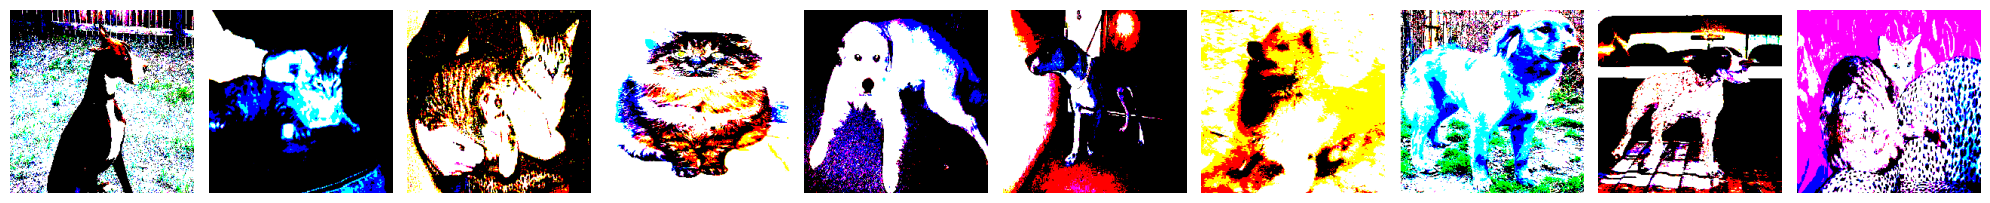

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [14]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [15]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
predictions = model.predict(x=test_batches, verbose=0)

In [17]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.

In [18]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [19]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title="Confusion matrix",
                         cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axix=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center", 
                color="white" if cm[i, j] > thresh  else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [20]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[32 18]
 [35 15]]


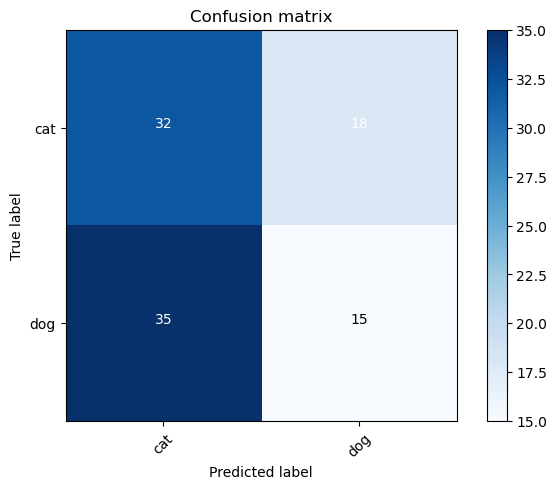

In [21]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

 ### 4. Build fine tuned VGG16 model

In [22]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [23]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
type(vgg16_model)

keras.engine.functional.Functional

In [25]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [27]:
for layer in model.layers:
    layer.trainable = False

In [28]:
model.add(Dense(units=2, activation='softmax'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

### 5. Train the fine-tuned VGG16 model

In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 506s - loss: 0.3426 - accuracy: 0.8540 - val_loss: 0.1064 - val_accuracy: 0.9550 - 506s/epoch - 5s/step
Epoch 2/5
100/100 - 507s - loss: 0.0885 - accuracy: 0.9700 - val_loss: 0.0699 - val_accuracy: 0.9750 - 507s/epoch - 5s/step
Epoch 3/5
100/100 - 496s - loss: 0.0568 - accuracy: 0.9770 - val_loss: 0.0645 - val_accuracy: 0.9800 - 496s/epoch - 5s/step
Epoch 4/5
100/100 - 509s - loss: 0.0415 - accuracy: 0.9860 - val_loss: 0.0611 - val_accuracy: 0.9800 - 509s/epoch - 5s/step
Epoch 5/5
100/100 - 496s - loss: 0.0313 - accuracy: 0.9950 - val_loss: 0.0577 - val_accuracy: 0.9800 - 496s/epoch - 5s/step


In [32]:
# assert model.history.history.get("accuracy")[-1] > 0.95

### 6. Predict using fine-tuned VGG16 model

In [33]:
predictions = model.predict(x=test_batches, verbose=0)  # "verbose=0" means do not want to see any output from our predictions

In [34]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [36]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[25 25]
 [25 25]]


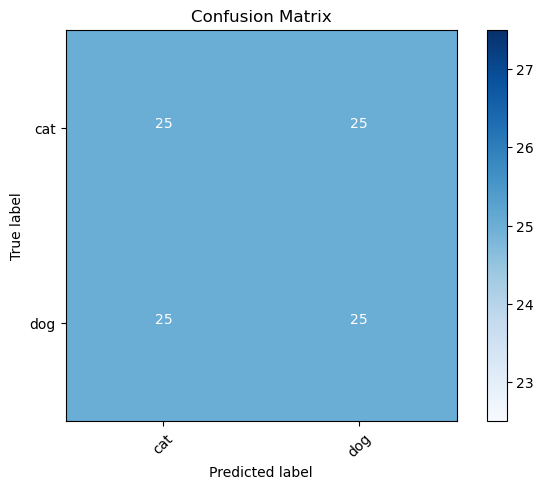

In [37]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

#### We noticed that VGG16 was actually  already trained on cats and dogs, so it didn't take a lot of fine tuning at all to get it to perform well on our cat and dog dataset